In [ ]:
!pip3 install gym
!pip3 install gym-retro
!pip -q install pyglet
!pip -q install pyopengl
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip3 install atari-py
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay



In [ ]:
import tensorflow as tf
import numpy as np
import retro       #retro environment of openai gym for games in atari
import gym
import keras
from skimage import transform #used to preprocess the frames
from skimage.color import rgb2gray #grescaling each frame
import matplotlib.pyplot as plt  #for graphs
from collections import deque  #orderedcollection with ends
import random
import warnings #ignore all warnings due to skimage 
warnings.filterwarnings('ignore')



In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

W0710 06:28:55.190234 140390961403776 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1003'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1003'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

#creating space invaders environment

In [ ]:
env= gym.make('SpaceInvaders-v0')
print("the size of our frame:" , env.observation_space)
print("the action size:" , env.action_space.n)
#coverting actions to one hot encoding
possible_actions= np.array(np.identity(env.action_space.n,dtype=int).tolist())


the size of our frame: Box(210, 160, 3)
the action size: 6


# Preprocessing frames


*   preprocessing is done to reduce complexity of our states in turn reducing computational time for training
*  rgb(3d) to greyscale(1d) as color doesnt add any advantage

*  next we crop frames for only usable screen
*  normalize pixels
*  finally we resize frames









In [ ]:
def preprocess_frame(frame):
  gray=rgb2gray(frame)
  #cropping the screen (remove the part below the player)
  #[up:down,left:right]
  cropped_frame= gray[8:-12,4:-12]
  #normalize pixel values
  normalized_frame= cropped_frame/255.0
  preprocessed_frame = transform.resize(normalized_frame,[110,84])
  
  return preprocessed_frame #110x84x1

# STACK FRAMES

*   important to implement as it gives sense of motion
*   as per deep mind paper we r following frame selecting parameter is set to 4 so for each timestep we skip 4 frames and this frame to form stack_frame this method is already implemented in library
*   we append frame to deque which removes oldest frame after every timesteps 
*   we stack up these frames iteratively and define a state through this we do this until the end of episode





In [ ]:
stack_size = 4
#initializing deque with zero images one array for each image
stacked_frames = deque([np.zeros((110,84), dtype= np.int)for i in range(stack_size)],maxlen=4)
def stack_frames(stacked_frames, state, is_new_episode):
  frame = preprocess_frame(state)
  #preprocessing step
  
  if is_new_episode:
    stack_frames=deque([np.zeros((110,84), dtype= np.int)for i in range(stack_size)],maxlen=4)
    #resetting frames on encountering a new episode
    stacked_frames.append(frame)
    stacked_frames.append(frame)
    stacked_frames.append(frame)
    stacked_frames.append(frame)   #copying same frame 4xin each new episode
    
    stacked_state= np.stack(stacked_frames,axis=2)
  else:
    stacked_frames.append(frame)  #automatically append frame to deque removes oldest
    stacked_state= np.stack(stacked_frames, axis=2) #form a stack
    
  return stacked_state, stacked_frames  

# Hyperparameters setting up 
first we define neural networks hyperparameters
then hparam for training algo

In [ ]:
#model hparam..
state_size = [110,84,4]    #input of stack frames
action_size = env.action_space.n  #6 possible actions
learning_rate = 0.0025  #alpha
#traning hparam
total_episodes = 50
max_steps = 50000
batch_size = 64
#exploration/exploitation tradeoff using epsilon greedy strategy
explore_start =1.0       
explore_stop = 0.01
decay_rate = 0.00001
#q learning hyperparam
gamma= 0.9

#memory hparam
pretrain_length = batch_size  #no.of experiences stored in memory when initialized for first time
memory_size= 1000000          #no. of experiences memory can keep

#preprocessing hparam
stack_size = 4               #no. of frames stacked
training = True
episode_render = False 


# creating our deep q-learning NN model
architecture:-
*   we pass input a stack of 4 frames
*   pass it through 3 covnets
*   it is flattened
*   pass it through 2 fc layers
* outputs a q value for each action



In [ ]:
class DQNetwork:
  def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
    self.state_size = state_size
    self.action_size = action_size     #constructor initialising
    self.learning_rate = learning_rate
    
    with tf.variable_scope(name):      #we create the placeholders
                                       #*state_size means that we take each element of statesize in tuple
                                       # like [none,84,84,4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 64,
                                 kernel_size = [3,3],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer='he_normal',
                                 name = "conv3")

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                         units = 512,
                                         activation = tf.nn.elu,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name="fc1")
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           units = self.action_size, 
                                           activation=None)
            

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
    

In [ ]:
tf.reset_default_graph()   #reset the graph
DQNetwork = DQNetwork(state_size, action_size, learning_rate) #instantiate the DQNetwork

W0710 06:28:58.013537 140390961403776 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0710 06:28:58.015430 140390961403776 deprecation.py:323] From <ipython-input-23-e1bd3b6c4f96>:28: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0710 06:28:58.335047 140390961403776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flat

# EXPERIENCE REPLAY
here we will create memory object that creates a deque. A deque (double ended queue) is a data type that removes the oldest element each time u add a new element 




In [ ]:
class Memory():
  def __init__(self,max_size):
    self.buffer = deque(maxlen = max_size)    #initialize replay buffer
  
  def add(self,experience):
    self.buffer.append(experience)            #fx for adding experience to buffer folder
  
  def sample(self, batch_size):
    buffer_size = len(self.buffer)
    index = np.random.choice(np.arange(buffer_size),  #RANDOMLY CHOOSING EXPERIENCE SAMPLES FROM THE REPLAY BUFFER TO AVOID CORRELATION B/W EXPERINCES
                             size = batch_size,
                              replace = False)
    return [self.buffer[i] for i in index]

TO REMOVE EMPTY MEMORY PROBLEM ... we'll prepopulate our memory by taking random action in starting to obtain some experiences and storing them (state, action,reward,next_state) 

In [ ]:
#instantiate memory
memory = Memory(max_size= memory_size)
for i in range(pretrain_length):
  # if its the first step
  if i==0:
    state = env.reset()
    
    state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Get the next_state, the rewards, done by taking a random action
  choice = random.randint(1,len(possible_actions))-1
  action = possible_actions[choice]
  next_state, reward, done, __ = env.step(env.action_space.sample())
    
    #env.render()
    
    # Stack the frames
  next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    
    
    # If the episode is finished (we're dead 3x)
  if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
  else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state

# set up tensorboard

In [ ]:
#setup tensorboard writer
writer = tf.summary.FileWriter("/tensorboard/dqn/1")

#loses
tf.summary.scalar("Loss",DQNetwork.loss)

write_op = tf.summary.merge_all()

# Training our agent
our algo:
initialize w
init our environment
initialize decay rate(for epsilon deduction)

for episode to max episode DO
make new episode
set step 0
observe the first state s0

while steps<max steps do:
                increase decay_rate
                with e select a random action at 

In [ ]:
"""
This function will do the part
With ϵϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability

In [ ]:
# Saver will help us to save our model
saver = tf.train.Saver()

if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            rewards_list = []
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            while step < max_steps:
                step += 1
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(env.action_space.sample())
                
                if episode_render:
                    env.render()
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros((110,84), dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                                  'Total reward: {}'.format(total_reward),
                                  'Explore P: {:.4f}'.format(explore_probability),
                                'Training Loss {:.4f}'.format(loss))

                    rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                  # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    

                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state 
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/model.ckpt")
                print("Model Saved")

Episode: 0 Total reward: 185.0 Explore P: 0.9903 Training Loss 0.8899
Model Saved
Episode: 1 Total reward: 210.0 Explore P: 0.9824 Training Loss 1.9718
Episode: 2 Total reward: 105.0 Explore P: 0.9768 Training Loss 0.4083
Episode: 3 Total reward: 180.0 Explore P: 0.9679 Training Loss 14.6308
Episode: 4 Total reward: 35.0 Explore P: 0.9631 Training Loss 2.2972
Episode: 5 Total reward: 565.0 Explore P: 0.9507 Training Loss 75.8877
Model Saved
Episode: 6 Total reward: 40.0 Explore P: 0.9448 Training Loss 44.3612
Episode: 7 Total reward: 125.0 Explore P: 0.9371 Training Loss 29.1331
Episode: 8 Total reward: 110.0 Explore P: 0.9324 Training Loss 2.4983
Episode: 9 Total reward: 180.0 Explore P: 0.9263 Training Loss 23.2217
Episode: 10 Total reward: 105.0 Explore P: 0.9231 Training Loss 5.4311
Model Saved
Episode: 11 Total reward: 75.0 Explore P: 0.9184 Training Loss 3.4596
Episode: 12 Total reward: 120.0 Explore P: 0.9119 Training Loss 26.5921
Episode: 13 Total reward: 5.0 Explore P: 0.9084 

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

W0710 07:01:49.043086 140390961403776 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1007'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1007'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)


W0710 07:01:50.087023 140390961403776 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


KeyboardInterrupt: ignored

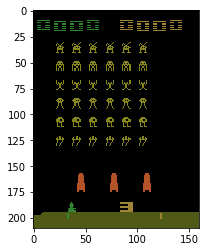

In [ ]:
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for episode in range(total_episodes):
  
  for i in range(max_steps):
    state = env.reset()
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
      break

ipythondisplay.clear_output(wait=True)
env.close()


# watching our agent to play

KeyboardInterrupt: ignored

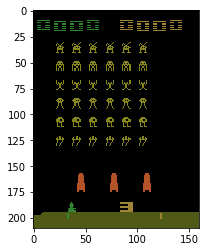

In [ ]:
with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, "./models/model.ckpt")
    
    for episode in range(1):
        total_rewards = 0
        
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        while True:
            # Reshape the state
            state = state.reshape((1, *state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[choice]
            
            #Perform the action and get the next_state, reward, and done information
            prev_screen = env.render(mode='rgb_array')
            plt.imshow(prev_screen)

            for episode in range(total_episodes):
  
                for i in range(max_steps):
                      state = env.reset()
                      action = env.action_space.sample()
                      obs, reward, done, _ = env.step(action)
                      screen = env.render(mode='rgb_array')

                      plt.imshow(screen)
                      ipythondisplay.clear_output(wait=True)
                      ipythondisplay.display(plt.gcf())

                      #next_state, reward, done, _ = env.step(env.action_space.sample())
                      #env.render()
            
                      total_rewards += reward

                if done:
                    print ("Score", total_rewards)
                    total_test_rewards.append(total_rewards)
                    break
                
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
            
    env.close()